In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### load_and_preprocess

1. Load CSV Files
2. Standardize Column Names
3. Merge sales and stock tables on date and product_id
4. Campaign_dates_df includes a row for each day a campaign is active. merge it to dataset. Clean ActiveCampaign "NA" values with binary 0

In [ ]:
def load_and_preprocess(sales_path, campaign_path, stock_path):
    # Load data
    sales_df = pd.read_csv(sales_path, sep=';', parse_dates=['Date'])
    campaign_df = pd.read_csv(campaign_path, sep=';', parse_dates=['ValidFrom', 'ValidTo'])
    stock_df = pd.read_csv(stock_path, sep=';', parse_dates=['Datum'])
    
    # Rename columns
    stock_df.rename(columns={'Datum': 'Date', 'AnonymniProdukt': 'Product', 'Mnozstvi': 'Stock'}, inplace=True)
    
    # Merge sales with stock data
    merged_df = pd.merge(sales_df, stock_df, on=['Date', 'Product'], how='left')
    
    # Handle missing stock: assume missing means zero stock
    merged_df['Stock'] = merged_df['Stock'].fillna(0)
    
    # Process campaigns to create ActiveCampaign feature
    campaign_dates = []
    for _, row in campaign_df.iterrows():
        dates = pd.date_range(row['ValidFrom'], row['ValidTo'], freq='D')
        temp_df = pd.DataFrame({
            'Date': dates,
            'Product': row['Product'],
            'Country': row['Country'],
            'ActiveCampaign': 1
        })
        campaign_dates.append(temp_df)
    
    campaign_dates_df = pd.concat(campaign_dates, ignore_index=True)
    merged_df = pd.merge(merged_df, campaign_dates_df, on=['Date', 'Product', 'Country'], how='left')
    merged_df['ActiveCampaign'] = merged_df['ActiveCampaign'].fillna(0)
    
    return merged_df

def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

### Before training, your data must be:

1. Numerical (no strings in features, also uint type is not desirable)
2. No NaNs
3. Sorted by Date (especially for lag features)

### Included features:

1. Lag feature( 'StockLag1', 'StockLag7' with lag of 1 and 7 days respectively.)

    - Capture the stock level of a product from previous days.
    - Useful to predict current demand based on past availability

2. Moving Averages (StockMA7, StockMA14)

    - Creates a binary trend feature for modeling, can be used like:

        >If StockMA7 > StockMA14: Short-term stock increase.
        
        >If StockMA7 < StockMA14: Potential downward trend.

In [16]:
def create_features(df):
    # Temporal features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(np.int32)
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['DayOfMonth'] = df['Date'].dt.day
    
    # Lag and moving average features for stock
    df = df.sort_values(['Product', 'Date'])
    df['StockLag1'] = df.groupby('Product')['Stock'].shift(1)
    df['StockLag7'] = df.groupby('Product')['Stock'].shift(7)
    df['StockMA7'] = df.groupby('Product')['Stock'].transform(lambda x: x.rolling(7, min_periods=1).mean())
    df['StockMA14'] = df.groupby('Product')['Stock'].transform(lambda x: x.rolling(14, min_periods=1).mean())
    
    # Fill NaN in lag features
    df[['StockLag1', 'StockLag7', 'StockMA7', 'StockMA14']] = df[['StockLag1', 'StockLag7', 'StockMA7', 'StockMA14']].fillna(0)
    
    # Encode categorical variables
    df['CountryStatus'] = df['CountryStatus'].map({'A': 1, 'Z': 0})
    df['ProductStatus'] = df['ProductStatus'].map({'A': 1, 'Z': 0})
    df['StatusCombination'] = df['CountryStatus'].astype(str) + df['ProductStatus'].astype(str)
    
    le_country = LabelEncoder()
    le_product = LabelEncoder()
    df['CountryEncoded'] = le_country.fit_transform(df['Country'])
    df['ProductEncoded'] = le_product.fit_transform(df['Product'])
    
    return df

merged_df = load_and_preprocess('../data/sell_data_cleaned.csv', '../data/marketing_campaign.csv', '../data/stock.csv')
featured_df = create_features(merged_df)
missing_data(featured_df)


,Total,Percent,Types
ID,0,0.0,int64
Product,0,0.0,object
Date,0,0.0,datetime64[ns]
Quantity,0,0.0,float64
Country,0,0.0,object
CountryStatus,0,0.0,int64
ProductStatus,0,0.0,int64
Stock,0,0.0,float64
ActiveCampaign,0,0.0,float64
Year,0,0.0,int32


In [ ]:
def split_train_test(df, test_size=0.2):
    df = df.sort_values('Date')
    cutoff_idx = int(len(df) * (1 - test_size))
    cutoff_date = df.iloc[cutoff_idx]['Date']
    train_df = df[df['Date'] <= cutoff_date]
    test_df = df[df['Date'] > cutoff_date]
    return train_df, test_df, cutoff_date

def train_model(train_df, regressors, target='Quantity'):
    X_train = train_df[regressors]
    y_train = train_df[target]
    
    model = RandomForestRegressor(
        n_estimators=100,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        oob_score=False
    )
    model.fit(X_train, y_train)
    return model

def predict(model, test_df, features, target='Quantity'):
    test_df = test_df.copy()
    X_test = test_df[features]
    
    # Predict with the model
    test_df['Predicted'] = model.predict(X_test)
    
    # Optional: set predicted quantity to 0 where there's no stock
    if 'Stock' in test_df.columns:
        test_df.loc[test_df['Stock'] == 0, 'Predicted'] = 0

    return test_df


In [9]:
def plot_forecast(original, preds, split_date, title):
    plt.figure(figsize=(12,6), facecolor='#242424')
    plt.plot(original.index, original.values, label='Train+Test', color = '#fefefe')
    plt.plot(preds.index, preds.values, label='Predicted', linestyle='--', color = "red")
    plt.axvline(split_date, color='blue', linestyle=':')

    ax = plt.gca()
    ax.set_facecolor('#242424')
    ax.tick_params(axis='x', colors='#fefefe')
    ax.tick_params(axis='y', colors='#fefefe')
    ax.spines['bottom'].set_color('#fefefe')
    ax.spines['top'].set_color('#fefefe')
    ax.spines['right'].set_color('#fefefe')
    ax.spines['left'].set_color('#fefefe')
    plt.title(title, color='#fefefe')
    plt.xlabel('Date', color='#fefefe')
    plt.ylabel('Quantity', color='#fefefe')
    plt.legend(labelcolor='#fefefe', facecolor='#242424')
    plt.grid(False)
    plt.show()

In [14]:
def plot_method1(train_df, test_df, cutoff_date):

    # Optionally can specify the time period that should be plotted.
    lookback_period = pd.Timedelta(days=365*2)
    countries = train_df['Country'].unique()
    for country in countries:

        # Filtering the dataset. at this stage we could have specified product like this:
        #            train_country = train_df[(train_df['Country'] == country) & (train_df['Product'] == target_product)]
        # This method tho is getting all the products into consideration by summing all the Predicted and Quantity values below then plotting them.
        train_country = train_df[train_df['Country'] == country]
        test_country = test_df[test_df['Country'] == country]
        if len(test_country) == 0:
            continue
        combined = pd.concat([train_country, test_country])

        # Grouping all product by date, then summing the actual Quantity and Predicted.
        aggregated = combined.groupby('Date').agg({'Quantity': 'sum', 'Predicted': 'sum'}).reset_index()
        
        # if specifying time period(lookback_period) the uncomment below
        # train_agg = aggregated[(aggregated['Date'] <= cutoff_date) & (aggregated['Date'] >= cutoff_date - lookback_period)]
        train_agg = aggregated[aggregated['Date'] <= cutoff_date]
        test_agg = aggregated[aggregated['Date'] > cutoff_date]
        
        plt.figure(figsize=(12, 6))
        plt.plot(train_agg['Date'], train_agg['Quantity'], label='Train Actual', color='#fefefe')
        plt.plot(test_agg['Date'], test_agg['Quantity'], label='Test Actual', linestyle='-', color='yellow', alpha=0.5)
        plt.plot(test_agg['Date'], test_agg['Predicted'], label='Predicted', linestyle='-', color='red')
        ax = plt.gca()
        ax.set_facecolor('#242424')
        ax.tick_params(axis='x', colors='#fefefe')
        ax.tick_params(axis='y', colors='#fefefe')
        ax.spines['bottom'].set_color('#fefefe')
        ax.spines['top'].set_color('#fefefe') 
        ax.spines['right'].set_color('#fefefe')
        ax.spines['left'].set_color('#fefefe')
        plt.xlabel('Date', color='#fefefe') 
        plt.ylabel('Quantity', color='#fefefe')
        plt.legend(labelcolor='#fefefe', facecolor='#242424')
        plt.grid(False)
        plt.title(f'Method 1: Country {country}')
        plt.legend()
        plt.show()

In [34]:
def plot_method2(train_df, test_df, cutoff_date):
    combined = pd.concat([train_df, test_df])
    aggregated = combined.groupby('Date').agg({'Quantity': 'sum', 'Predicted': 'sum'}).reset_index()
    train_agg = aggregated[aggregated['Date'] <= cutoff_date]
    test_agg = aggregated[aggregated['Date'] > cutoff_date]
    
    plt.figure(figsize=(12, 6))
    plt.plot(train_agg['Date'], train_agg['Quantity'], label='Train Actual', color='#fefefe')
    plt.plot(test_agg['Date'], test_agg['Quantity'], label='Test Actual', linestyle='-', color='yellow', alpha=0.5)
    plt.plot(test_agg['Date'], test_agg['Predicted'], label='Predicted', linestyle='-', color='red')
    plt.title('Method 2: All Products and Countries')
    ax = plt.gca()
    ax.set_facecolor('#242424')
    ax.tick_params(axis='x', colors='#fefefe')
    ax.tick_params(axis='y', colors='#fefefe')
    ax.spines['bottom'].set_color('#fefefe')
    ax.spines['top'].set_color('#fefefe') 
    ax.spines['right'].set_color('#fefefe')
    ax.spines['left'].set_color('#fefefe')
    plt.xlabel('Date', color='#fefefe') 
    plt.ylabel('Quantity', color='#fefefe')
    plt.legend(labelcolor='#fefefe', facecolor='#242424')
    plt.grid(False)
    plt.legend()
    plt.show()


In [35]:
def plot_method3(train_df, test_df, cutoff_date):
    status_combinations = train_df['StatusCombination'].unique()
    for status in status_combinations:
        train_status = train_df[train_df['StatusCombination'] == status]
        test_status = test_df[test_df['StatusCombination'] == status]
        if len(test_status) == 0:
            continue
        combined = pd.concat([train_status, test_status])
        aggregated = combined.groupby('Date').agg({'Quantity': 'sum', 'Predicted': 'sum'}).reset_index()
        train_agg = aggregated[aggregated['Date'] <= cutoff_date]
        test_agg = aggregated[aggregated['Date'] > cutoff_date]
        
        plt.figure(figsize=(12, 6))
        plt.plot(train_agg['Date'], train_agg['Quantity'], label='Train Actual', color='#fefefe', linestyle='-')
        plt.plot(test_agg['Date'], test_agg['Quantity'], label='Test Actual', linestyle='-', color='yellow', alpha=0.5)
        plt.plot(test_agg['Date'], test_agg['Predicted'], label='Predicted', linestyle='-', color='red')
        ax = plt.gca()
        ax.set_facecolor('#242424')
        ax.tick_params(axis='x', colors='#fefefe')
        ax.tick_params(axis='y', colors='#fefefe')
        ax.spines['bottom'].set_color('#fefefe')
        ax.spines['top'].set_color('#fefefe') 
        ax.spines['right'].set_color('#fefefe')
        ax.spines['left'].set_color('#fefefe')
        plt.xlabel('Date', color='#fefefe') 
        plt.ylabel('Quantity', color='#fefefe')
        plt.legend(labelcolor='#fefefe', facecolor='#242424')
        plt.grid(False)
        plt.title(f'Method 3: Status {status}')
        plt.legend()
        plt.show()

In [30]:
merged_df = load_and_preprocess('../data/sell_data_cleaned.csv', '../data/marketing_campaign.csv', '../data/stock.csv')
featured_df = create_features(merged_df)
train_df, test_df, cutoff_date = split_train_test(featured_df)
train_df.head()

features = [
    'Year', 'Month', 'Week', 'DayOfWeek', 'DayOfMonth',
    'CountryEncoded', 'ProductEncoded', 'CountryStatus', 'ProductStatus',
    'ActiveCampaign', 'Stock', 'StockLag1', 'StockLag7', 'StockMA7', 'StockMA14'
]

print(train_df.columns.tolist())
model = train_model(train_df, features)

['ID', 'Product', 'Date', 'Quantity', 'Country', 'CountryStatus', 'ProductStatus', 'Stock', 'ActiveCampaign', 'Year', 'Month', 'Week', 'DayOfWeek', 'DayOfMonth', 'StockLag1', 'StockLag7', 'StockMA7', 'StockMA14', 'StatusCombination', 'CountryEncoded', 'ProductEncoded']


In [31]:
test_df = predict(model, test_df, features)

rmse = np.sqrt(mean_squared_error(test_df['Quantity'], test_df['Predicted']))
mae = mean_absolute_error(test_df['Quantity'], test_df['Predicted'])
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}')

RMSE: 25.19, MAE: 7.33


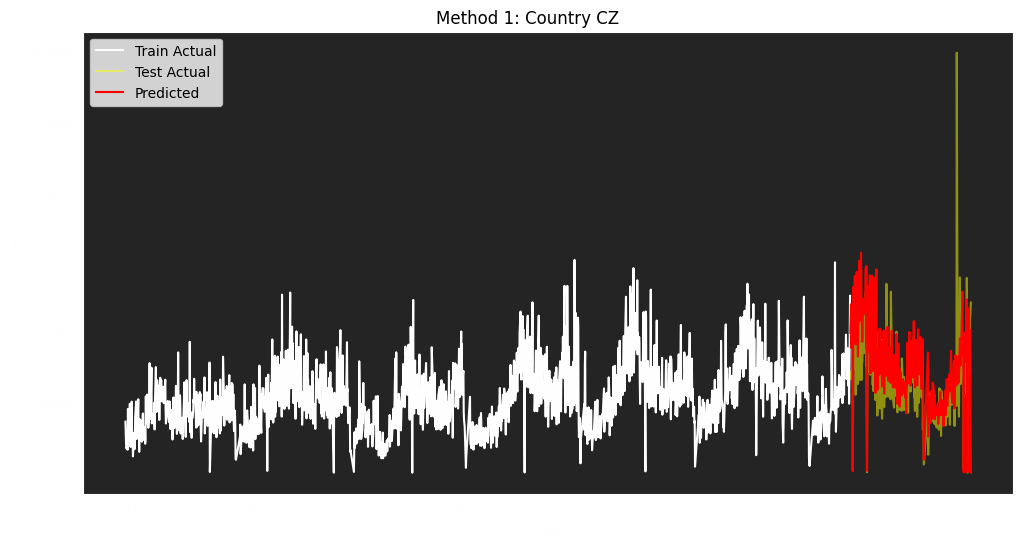

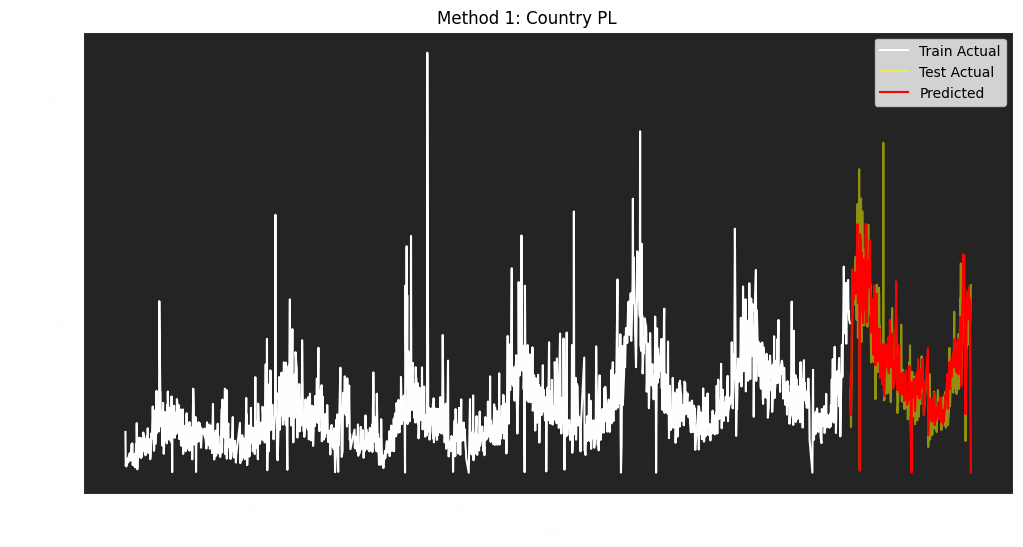

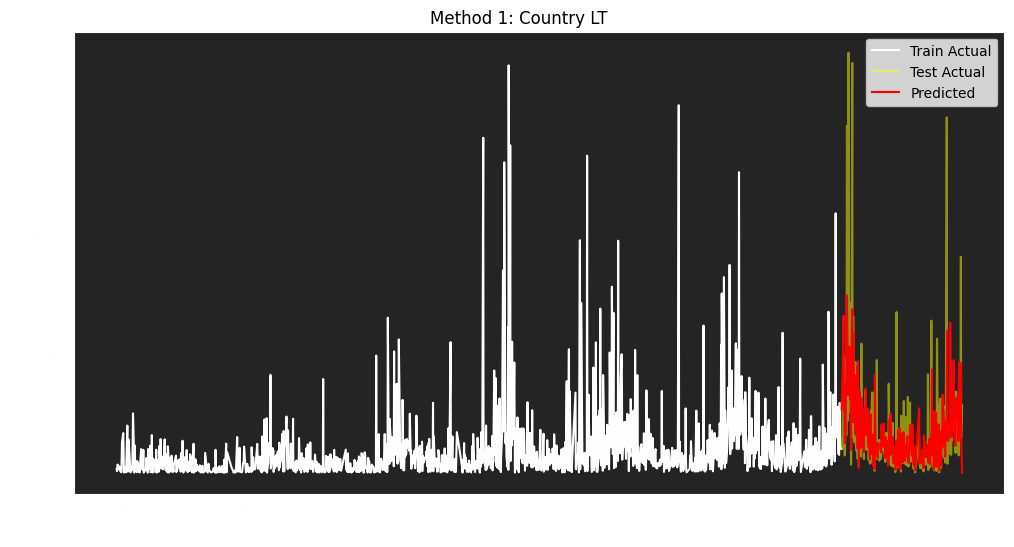

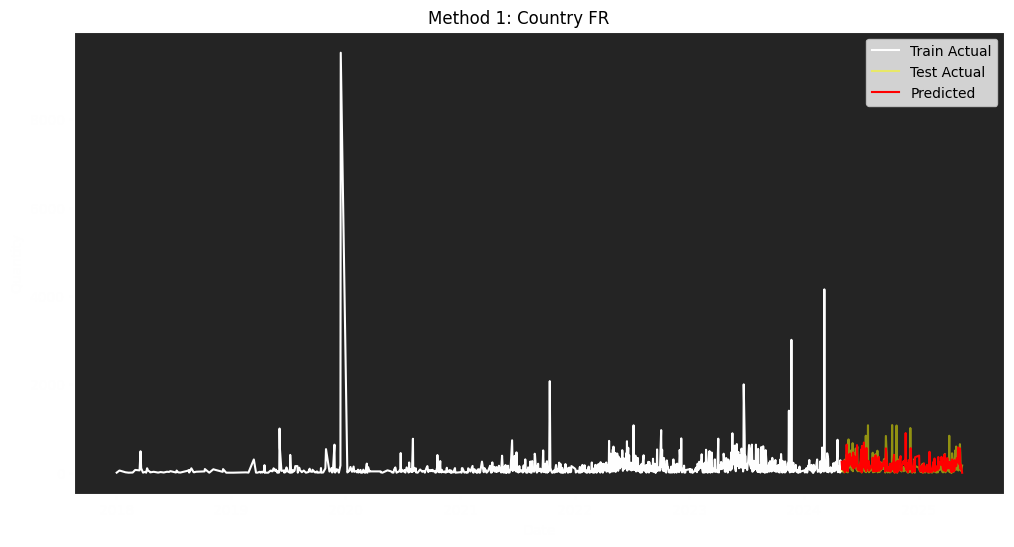

In [32]:
plot_method1(train_df, test_df, cutoff_date)

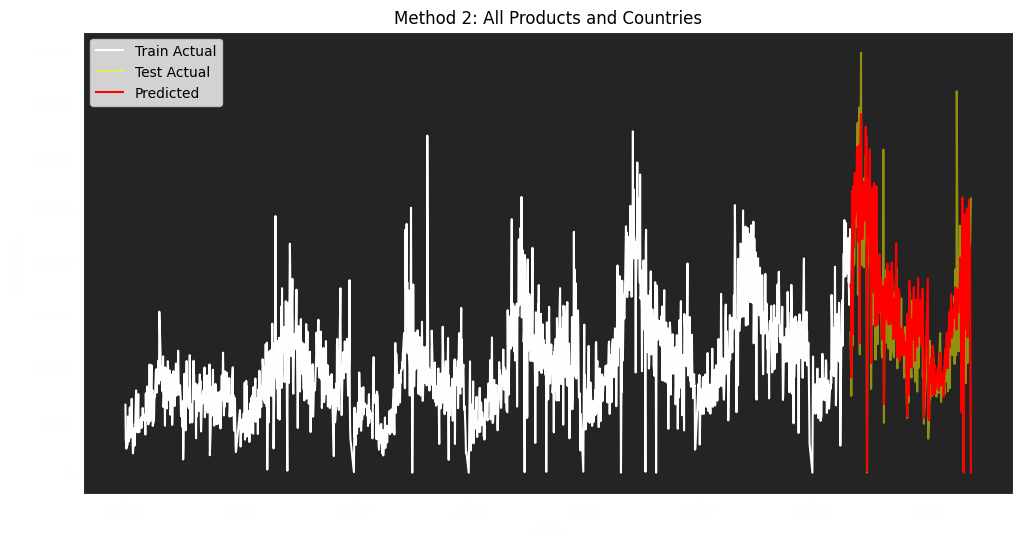

In [36]:
plot_method2(train_df, test_df, cutoff_date)

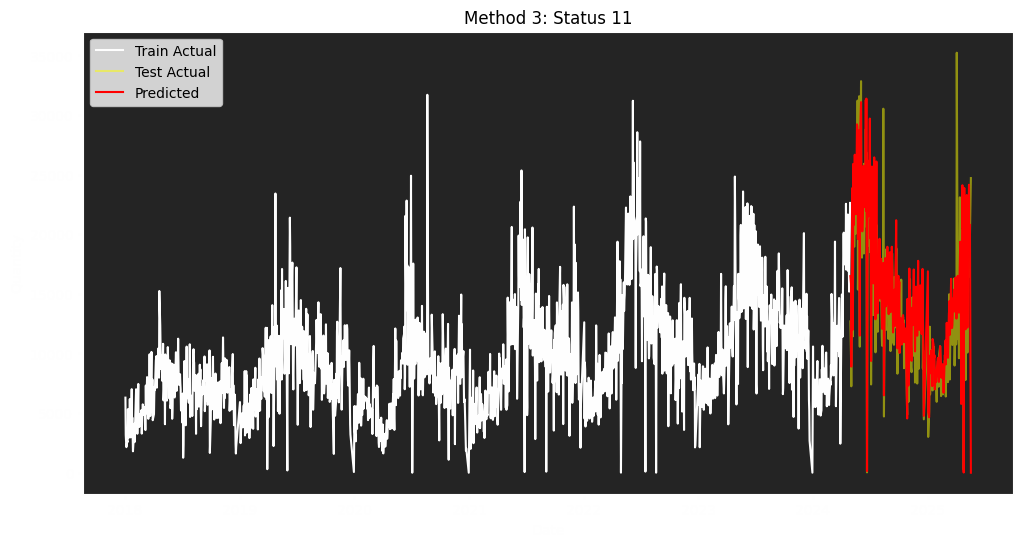

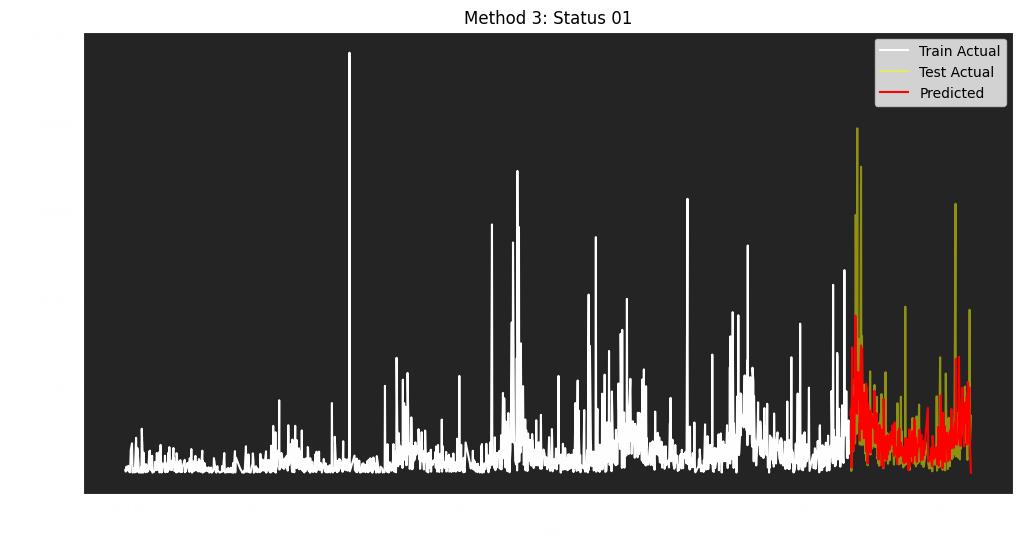

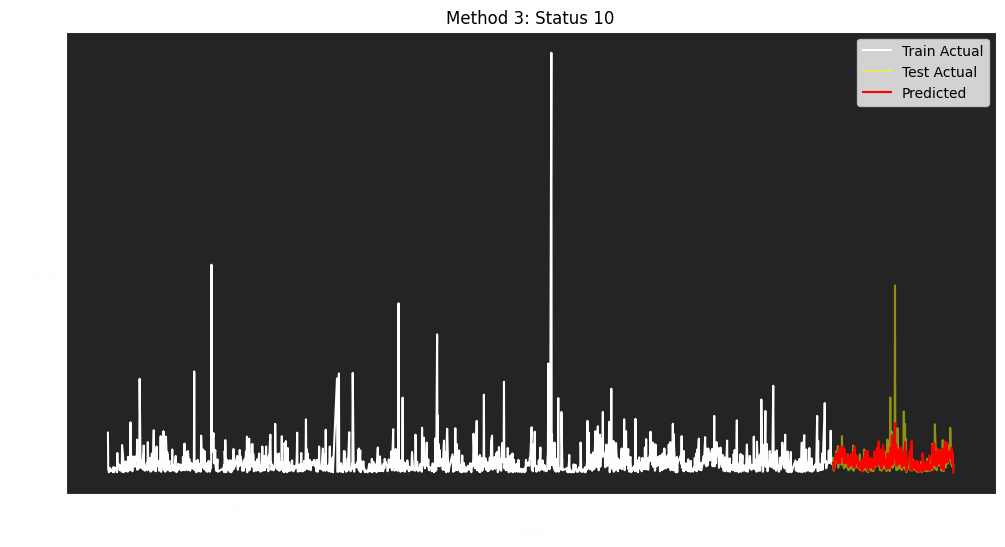

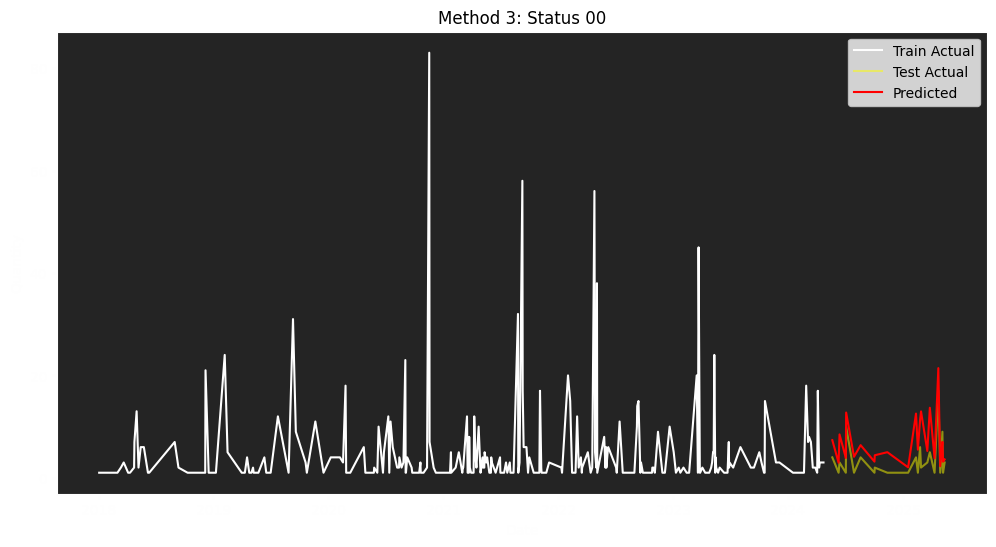

In [37]:
plot_method3(train_df, test_df, cutoff_date)